**Author and copyright: Juergen Koefinger, MPI of Biophysics, Frankfurt am Main, Germany, June (2022)**

Published under MIT license (see license.md)

# References

If you use BioEn, as in this notebook here to refine SAXS data, please cite

o Köfinger J. et al., J. Chem. Theory Comput. **15**(5), 3390-3401 (2019), http://dx.doi.org/10.1021/acs.jctc.8b01231

for the numerical solution of the underlying optimization problem, and 

o Hummer G. and Köfinger J., J. Chem. Phys. **43** 243150 (2015), http://dx.doi.org/10.1063/1.4937786

for the underlying theory. 


This notebook was tested with bioen verstion '0.1.1'

# Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, time, matplotlib
import SAXS_BioEn as saxs
import bioen.optimize as bop

In [2]:
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rc('axes', labelsize=16)

In [3]:
import bioen
bioen.version.get_version_string()

'0.1.1'

# Input 

## Calculated intensities

Read in the calcualted SAXS intensities for each structure in the ensemble. The filenames consist of a 'prefix', a value of the counter variable, and a format 'fmt' (file ending) string. You have to set the range 'idx_range' for the counter variable. The intensity files are text files with two columns. We have one file per structure. First column contains the values of the momentum transfer q. The second column contains the calculated intensity values. Note that the q-range is the same for all structure and it should be larger than for the experimental data. Intensities are stored in the numpy array 

In [4]:
i_path = "./input/model_intensities/"
prefix = "Iq_"
fmt = ".dat"
idx_range=[1, 100]
intensities = []
for i in range(idx_range[0], idx_range[-1]+1):
    file_name = prefix+"%d" % i + fmt
    intensities.append(np.loadtxt(i_path+file_name))
intensities = np.asarray(intensities)

Text(0.5, 1.0, 'Calculated intensities for ensemble')

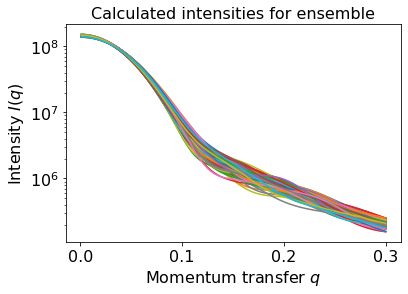

In [5]:
for intensity in intensities:
    plt.plot(intensity[:,0], intensity[:,1])
plt.xlabel("Momentum transfer $q$")
plt.ylabel("Intensity $I(q)$")
plt.yscale('log')
plt.title("Calculated intensities for ensemble", size=16)

## Experimental intensities

Read in the SAXS intensity measured in experiment and its errors. The intensity file is a text files with three columns. First column contains the values of the momentum transfer q. The second column contains the measured intensities. The third column contains the standard errors of the means. 

In [6]:
i_path = "./input/"
file_name = "experiment.dat"
Iq_exp = np.loadtxt(i_path+file_name)

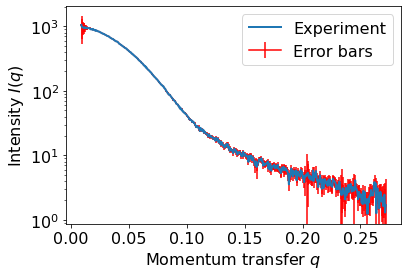

In [7]:
plt.errorbar(Iq_exp[:,0], Iq_exp[:,1], yerr=Iq_exp[:,2], c='r', label="Error bars")
plt.plot(Iq_exp[:,0], Iq_exp[:,1], lw=2, zorder=100, label="Experiment")
plt.legend(fontsize=16)
plt.xlabel("Momentum transfer $q$")
plt.ylabel("Intensity $I(q)$")
plt.yscale('log')

# BioEn

## Setup

To set up the BioEn refinement, we define the y matrix for the calculated SAXS data and the Y vector for the experimental data. The dimension of y are (M,N) and of Y are (1,M), where M is the number of values in the measured intensity and N is the number of structures. We scale these quantities by the standard error of the mean, which gives yTilde and YTilde (see Hummer and Koefinger, J. Chem. Phys. **143** (2015)).

In [8]:
Y=(np.matrix(Iq_exp[:,1]))
Y=np.asarray([Iq_exp[:,1]])
YTilde=Y/Iq_exp[:,2]
print(Y.shape)

(1, 520)


We adapt the q-range of the calculated intensities to match the experimental q-values. 

In [9]:
M = Iq_exp.shape[0] # number of experimental data points
N = intensities.shape[0] # number of structures 
y=np.zeros((M, N))
for i in range(N):
    y[:,i] = saxs.adapt_q_range(intensities[i], Iq_exp)[:,1]
yTilde = y/(Iq_exp[:,2][:, np.newaxis])
print(y.shape)

(520, 100)


We define the reference weights w0 with dimensions (N,1). Because simulations are unbiased, we use constant reference weights here. That is, all weights are 1/N. 

In [10]:
w0=(np.ones((N,1))/float(N))
print(w0.shape)

(100, 1)


## Initial fit 

We perform an intial fit of the calculated average intensity to the measured intensity, taking into account only  the experimental errors. We use a **scale parameter** $a$ and and an **offset parameter** $b$. That is, the fitted calculated intensity is given by $I'(q)=a*I(q)+b$. $b$ accounts for imperfect solvent signal correction in experiment (see Koefinger and Hummer PRE **87** (2013)) and for residual electron constrast differences between experiment and calculation.

In [11]:
a, b, f = saxs.fit_to_ave(w0, y, Iq_exp)

Text(0, 0.5, 'Intensity $I(q)$')

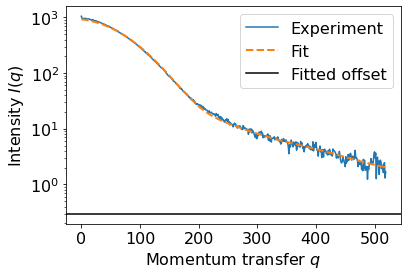

In [12]:
plt.plot(np.asarray(Y)[0], label="Experiment")
plt.plot(f(Iq_exp[:,0], a, b),'--', lw=2, label="Fit")
plt.axhline(b, c='black', label="Fitted offset")
plt.legend(fontsize=16)
plt.yscale('log')
plt.xlabel("Momentum transfer $q$")
plt.ylabel("Intensity $I(q)$")

Text(0, 0.5, 'Normalized residuals')

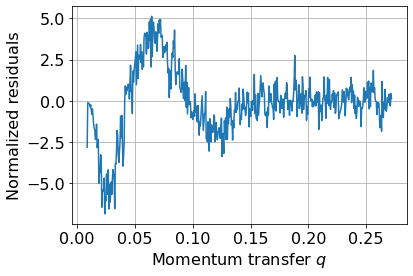

In [13]:
residuals_before_refinement = (f(Iq_exp[:,0], a, b) - Iq_exp[:,1])/Iq_exp[:,2]
plt.plot(Iq_exp[:,0], residuals_before_refinement)
plt.grid()
plt.xlabel("Momentum transfer $q$")
plt.ylabel("Normalized residuals")

## L-curve analysis

### Evaluation

We choose an optimziation algorithm and set default parameters for the BioEn solver.

In [14]:
bop_params=bop.minimize.Parameters("gsl")
print(bop_params)

{'minimizer': 'gsl', 'debug': True, 'verbose': True, 'params': {'step_size': 0.01, 'tol': 0.001, 'max_iterations': 5000}, 'n_threads': -1, 'cache_ytilde_transposed': 'auto', 'algorithm': 'gsl_multimin_fdfminimizer_vector_bfgs2', 'use_c_functions': True}


For BioEn, we perform an L-curve analysis. We define a series $\theta$, 'theta_range', which starts at the largest values (large confidence in simulations) and decreases to its lowest value (low confidence). Note that theta-values are chosen to be linear on a log-scale. 

We use the obtained optimal weights at one optimization step as new intial weights for the next optimization step at the next smaller value of $\theta$. 

At each step, i.e., at each $\theta$ value, we fit offset and scale parameter. We use the fitted values from the previous step for BioEn and the refit these values for the optimal parameters. Because these values change only slowly at each step, we obtain well converged results. 

In [15]:
theta_range=saxs.set_theta_list(-2, 5, 10)

In [16]:
# intialize log-weights method
gPrime, g, G, GInit = bop.log_weights.init_log_weights(w0)

In [17]:
# intialize forces method
forces_init = bop.forces.init_forces(M)

In the list 'results', lines contains [$\theta$, reduced chi-square, Kullback-Leibler divergence, scale parameter, offset parameter] for each step. At each step, we also save the optimal weights 'wopt' in a list 'wopts'.

In [18]:
# choose force method
method = "forces"
# choose log-weights method
method = "log-weights"

results = []
wopt_list=[]

a, b, f = saxs.fit_to_ave(w0, y, Iq_exp)
y_fit, yTilde_fit = saxs.update_y(a, b, y, yTilde)

# perform L-cuve analysis from large to small theta-values
for theta in theta_range:
    
    if method == 'forces':
        start=time.time()
        wopt_forces_mpcdf, yopt, forces_opt, fmin_initial, fmin_final, chiSqr_return, S_return = bop.forces.find_optimum(
                forces_init, w0, y_fit, yTilde_fit, YTilde, theta, bop_params)
        end=time.time()
        T=end-start
        F=fmin_final 
        wopt=wopt_forces_mpcdf

        forces_init=np.transpose([forces_opt.copy()])

    if method == 'log-weights':
        start=time.time()
        wopt_g_mpcdf, yopt_w, gopt, fmin_initial, fmin_final = bop.log_weights.find_optimum(GInit, G, 
                                        y_fit, yTilde_fit, YTilde, theta, bop_params)
        end=time.time()
        T=end-start
        F=fmin_final 
        wopt=wopt_g_mpcdf
        GInit=np.transpose([gopt.copy()])
    # second fitting of offset and scale parameters  
    a, b, f = saxs.fit_to_ave(wopt, y, Iq_exp)
    y_fit, yTilde_fit = saxs.update_y(a, b, y, yTilde)
    
    SKL = saxs.KL(wopt.T[0], w0.T[0])
    chi_sqr = 2.*bop.common.chiSqrTerm(wopt, yTilde_fit, YTilde)
    red_chi_sqr = chi_sqr/float(M)
    wopt_list.append(np.asarray(wopt.T)[0])
    results.append([theta, red_chi_sqr, SKL, a, b ])
results = np.asarray(results)
wopts = np.asarray(wopt_list)

fmin_initial 1051.3155301823726
---------------------
LOGW -- Library GSL/C
---------------------
time elapsed  0.0015969276428222656
fmin_initial  =  1051.3155301823726
fmin_final    =  1038.0161177430898
fmin_initial 1036.5740374316383
---------------------
LOGW -- Library GSL/C
---------------------
time elapsed  0.0010437965393066406
fmin_initial  =  1036.5740374316383
fmin_final    =  1035.8082647071092
fmin_initial 1032.8223492368888
---------------------
LOGW -- Library GSL/C
---------------------
time elapsed  0.0016739368438720703
fmin_initial  =  1032.8223492368888
fmin_final    =  1031.9685249340416
fmin_initial 1028.241859017335
---------------------
LOGW -- Library GSL/C
---------------------
time elapsed  0.0012068748474121094
fmin_initial  =  1028.241859017335
fmin_final    =  1027.191730057928
fmin_initial 1022.5914186963616
---------------------
LOGW -- Library GSL/C
---------------------
time elapsed  0.0021181106567382812
fmin_initial  =  1022.5914186963616
fmin_fina

### Plotting

In the L-curve analysis, we select a $\theta$ according to the shape of the (SKL, red. chi-square) curve, where SKL is the Kullback-Leibler divergence. We do so by selecting and index 'idx', e.g. in the ellbow of the plot or where the reduced chi-square is close to one. 

In [19]:
idx=35
theta_opt = results[idx,0]
SKL_opt   = results[idx,2]
chi_square_opt = results[idx,1]
a_opt = results[idx][3]
b_opt = results[idx][4]
print("     theta[%d] = %3.2e" % (idx, theta_opt))
print("      S_KL[%d] = %3.2f" % (idx, SKL_opt))
print("chi-square[%d] = %3.2f" % (idx, chi_square_opt))
print()
print("  scale parameter a = %3.2e" % a)
print(" offset parameter b = %3.2e" % b)

     theta[35] = 3.16e+01
      S_KL[35] = 1.32
chi-square[35] = 0.73

  scale parameter a = 6.70e-06
 offset parameter b = -8.37e-02


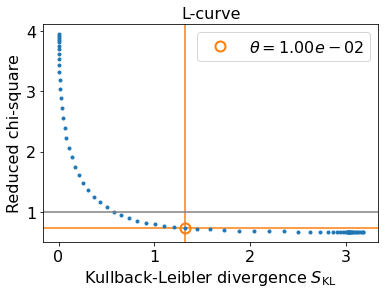

In [20]:
plt.plot(results[:,2], results[:,1], '.')
plt.axhline(1, color="gray")
plt.plot(SKL_opt, chi_square_opt, 'o', mfc="None", ms=10, mew=2, label=r"$\theta=%3.2e$" % theta)
plt.axhline(chi_square_opt, color="C1", zorder=-100)
plt.axvline(SKL_opt, color="C1", zorder=-100)
plt.xlabel("Kullback-Leibler divergence $S_\mathrm{KL}$")
plt.ylabel("Reduced chi-square")
plt.title("L-curve", size=16)
plt.legend(fontsize=16)

As a check of consistency, we plot the scale parameter as a function of $\theta$. Note that we perform the L-curve analysis by going from large values of $\theta$ (large confidence) to low values of $\theta$ (low confidence). 

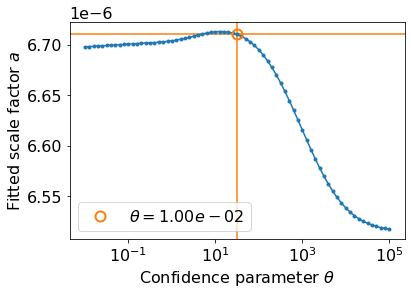

In [21]:
plt.plot(results[:,0], results[:,3], '.-')
plt.plot(theta_opt, a_opt, 'o', mfc="None", ms=10, mew=2, label=r"$\theta=%3.2e$" % theta)
plt.axhline(a_opt, color="C1", zorder=-100)
plt.axvline(theta_opt, color="C1", zorder=-100)
plt.xscale("log")
plt.xlabel(r"Confidence parameter $\theta$")
plt.ylabel(r"Fitted scale factor $a$")
plt.legend(fontsize=16)

As a check of consistency, we plot the offset parameter as a function of $\theta$. Note that we perform the L-curve analysis by going from large values of $\theta$ (large confidence) to low values of $\theta$ (low confidence). 

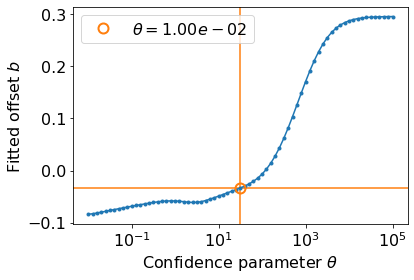

In [22]:
plt.plot(results[:,0], results[:,4], '.-')
plt.plot(theta_opt, results[idx,4], 'o', mfc="None", ms=10, mew=2, label=r"$\theta=%3.2e$" % theta)
plt.axhline(b_opt, color="C1", zorder=-100)
plt.axvline(theta_opt, color="C1", zorder=-100)
plt.xlabel(r"Confidence parameter $\theta$")
plt.ylabel(r"Fitted offset $b$")
plt.xscale("log")
plt.legend(fontsize=16)

## Results 

In [23]:
# define the reference weights as numpy array
wref=w0.T[0]

We plot the reference weights and the selected optimal weights (idx). We first structures by the size of their weights from largest weight to smalles weight. The closer the line for the optimal weights is to the reference weights, the closer are the two ensembles. 

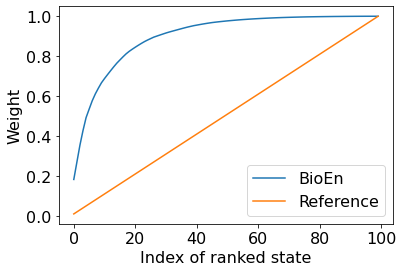

In [24]:
plt.plot(np.sort(wopts[idx])[::-1].cumsum(), label="BioEn")
plt.plot(wref.cumsum(), label="Reference")
plt.xlabel("Index of ranked state")
plt.ylabel("Weight")
plt.legend(fontsize=16)

### BioEn result for calculated intensities matched to experiment

We first show our optimal BioEn refinement for the calculated intensities truncated to the q-range of the experiment. Doing so, we can easily plot the residuals. Additionally, we show the offset as a horizontal line as a consistency check. 

In [25]:
y_fit, yTilde_fit = saxs.update_y(a, b, y, yTilde)
Iq_ave = (wopts[idx][:,np.newaxis]*np.asarray(y_fit.T)).sum(axis=0)

Text(0.5, 1.0, '$\\theta = 3.16e+01$')

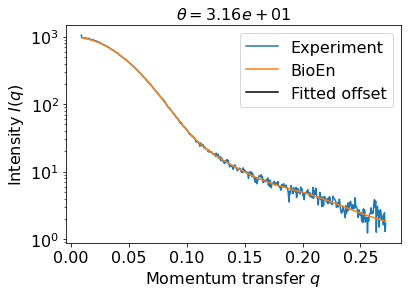

In [26]:
plt.plot(Iq_exp[:,0], Iq_exp[:,1], label="Experiment")
plt.plot(Iq_exp[:,0], Iq_ave, label="BioEn")
plt.axhline(b, color='k', label="Fitted offset")
plt.xlabel("Momentum transfer $q$")
plt.ylabel("Intensity $I(q)$")
plt.yscale('log')
plt.legend(fontsize=16)
plt.title(r"$\theta = %3.2e$" % results[idx,0], size=16)

Text(0.5, 1.0, '$\\theta = 3.16e+01$')

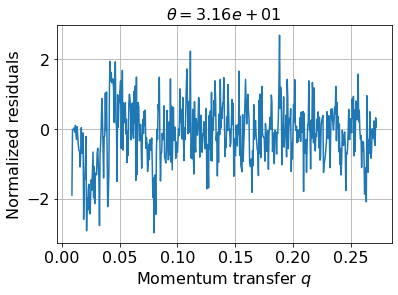

In [27]:
residuals_after_refinement = (Iq_ave - Iq_exp[:,1])/Iq_exp[:,2]
plt.plot(Iq_exp[:,0], residuals_after_refinement)
plt.grid()
plt.xlabel("Momentum transfer $q$")
plt.ylabel("Normalized residuals")
plt.title(r"$\theta = %3.2e$" % results[idx,0], size=16)

### BioEn result for full calculated intensities

We next show our optimal BioEn refinement for the calculated intensities over their full q-range. The refined intensity contains more information and can, for example, be used to determine the radius of gyration. Additionally, we show the offset as a horizontal line as a consistency check. 

In [28]:
M_full = intensities[0].shape[0]
q_list = intensities[0][:,0]
y_full=np.zeros((M_full, N))
for i in range(N):
    y_full[:,i] = intensities[i][:, 1]
#y_full = np.matrix(y_full)

In [29]:
y_full_fit, dummy = saxs.update_y(a, b, y_full, yTilde)
Iq_ave = (wopts[idx][:,np.newaxis]*np.asarray(y_full_fit.T)).sum(axis=0)

Text(0.5, 1.0, '$\\theta = 3.16e+01$')

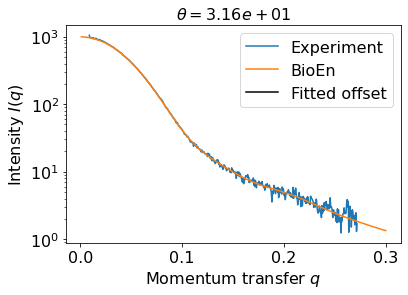

In [30]:
plt.plot(Iq_exp[:,0], Iq_exp[:,1], label="Experiment")
plt.plot(q_list, Iq_ave, label="BioEn")
plt.axhline(b, color='k', label="Fitted offset")
plt.xlabel("Momentum transfer $q$")
plt.ylabel("Intensity $I(q)$")
plt.yscale('log')
plt.legend(fontsize=16)
plt.title(r"$\theta = %3.2e$" % results[idx,0], size=16)

# Hplusminus statistics to check for the goodness-of-refinement

Powerful statistical tests for ordered data, Köfinger J. and Hummer G. (preprint) https://doi.org/10.26434/chemrxiv-2021-mdt29-v3 (2020)

See https://github.com/bio-phys/hplusminus for documentation and installation instructions (e.g., pip install --user hplusminus).

Note that for this example p-values are low and close to zero due to correlations in the residuals even for strong refinement. In this sense, this example is not a great choice to illustrate the power the hplusminus statistics. Please try with different data. 

In [31]:
import hplusminus.evaluate

In [32]:
res={}
res['before']= hplusminus.evaluate.all_statistical_tests(residuals_before_refinement)
res['after'] = hplusminus.evaluate.all_statistical_tests(residuals_after_refinement)

In [33]:
for test in ['h', 'chi2', 'chi2_h']:
    print("%s-test" % test) 
    for k in ['before', 'after']:
        print("    p-value %s refinement = %3.2e" % (k, res[k][test]['p']))

h-test
    p-value before refinement = 0.00e+00
    p-value after refinement = 6.61e-13
chi2-test
    p-value before refinement = 0.00e+00
    p-value after refinement = 1.56e-05
chi2_h-test
    p-value before refinement = 0.00e+00
    p-value after refinement = 8.88e-16
